In [1]:
import pyro
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO, Predictive, TraceEnum_ELBO
from pyro.optim import ClippedAdam
from torch.utils.data import TensorDataset, DataLoader


from pyro_mixture_model import MixtureModel, MixtureModelGuide
from Preprocess_data import create_summed_df
from utils import split_patient_level, summarize_columns
# set random seed for reproducibility
np.random.seed(42)

experiment_name = "mean_vi_no_clamp_on_mu_10_11_batch_pca"
save_dir = os.path.join("outputs", experiment_name)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

c:\Users\marie\miniconda3\envs\mbml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data and prepare it

In [2]:
if not os.path.exists("data/CaseRigshospitalet_summed.parquet"):
    print("Creating data file")
    create_summed_df()
print("Loading data file")
df = pd.read_parquet("data/CaseRigshospitalet_summed.parquet")

print("Number of data points ", len(df))
print("Number of patients ", len(df["Patient ID"].unique()))
summarize_columns(df)

Loading data file
Number of data points  497198
Number of patients  331647
                           name     dtype  unique  size (MB)
0                    Patient ID  category  331647         30
1           Aktionsdiagnosekode  category    8167          1
2  totalDiagnoseKontaktVarighed   float32    8160          1
3                antalKontakter     int64     141          3
4                antalDiagnoser     int64      17          3
5                         alder   Float64   14014          4
6                        gender  category       4          0
7                    civilStand  category       4          0
8          distanceToHospitalKM   float64    1772          3
Total size (excluding "embedding"): 50.595398902893066 MB


### Create train and test data split

In [20]:
total_samples=100000
(x_emb_train, d_demo_train, v_time_train, a_count_train), (x_emb_test, d_demo_test, v_time_test, a_count_test) = split_patient_level(df, total_samples=total_samples)

Demographic columns: ['alder', 'distanceToHospitalKM', 'gender_Kvinde', 'gender_Mand', 'gender_Ukendt', 'civilStand_Fraskilt', 'civilStand_Gift', 'civilStand_Ugift']


### Investigate data

In [21]:
# mean of train v_time
mean_v_time = torch.mean(v_time_train)
print(f"Mean v_time: {mean_v_time}")
print("Minimum v_time: ", torch.min(v_time_train))
print("Maximum v_time: ", torch.max(v_time_train))

a_count_train = a_count_train.to(torch.float32)
mean_a_count = torch.mean(a_count_train).log()
print(f"Mean a_count: {mean_a_count}")
print("Minimum a_count: ", torch.min(a_count_train))
print("Maximum a_count: ", torch.max(a_count_train))

# mean of test v_time
mean_v_time_test = torch.mean(v_time_test)
print(f"Mean v_time_test: {mean_v_time_test}")
print("Minimum v_time_test: ", torch.min(v_time_test))
print("Maximum v_time_test: ", torch.max(v_time_test))

Mean v_time: 4.136702537536621
Minimum v_time:  tensor(0.0200, dtype=torch.float32)
Maximum v_time:  tensor(435.3400, dtype=torch.float32)
Mean a_count: 1.3036644458770752
Minimum a_count:  tensor(1., dtype=torch.float32)
Maximum a_count:  tensor(225., dtype=torch.float32)
Mean v_time_test: 4.044698715209961
Minimum v_time_test:  tensor(0.0200, dtype=torch.float32)
Maximum v_time_test:  tensor(384.5900, dtype=torch.float32)


### Preprocess data
First, we perform a pca to diminish the dimensions of the bert embeddings of the text, $x$.

In [22]:
# PCA on x_emb_train
from sklearn.decomposition import PCA
# Fit PCA and choose number of components by covering 95% of variance
pca = PCA(n_components=0.95)
pca.fit(x_emb_train.numpy())
print(f"Number of PCA components: {pca.n_components_}")
# Transform the data
x_emb_train_pca = torch.tensor(pca.transform(x_emb_train.numpy()), dtype=torch.float32)
x_emb_test_pca = torch.tensor(pca.transform(x_emb_test.numpy()), dtype=torch.float32)
print("Shape of x_emb_train: ", x_emb_train.shape)
print("Shape of x_emb_train_pca: ", x_emb_train_pca.shape)

Number of PCA components: 150
Shape of x_emb_train:  torch.Size([80017, 768])
Shape of x_emb_train_pca:  torch.Size([80017, 150])


Then we standardize the input $x$ and $d$. The output visitation time, $v$, is log transformed (to allow use of a normal function to estimate) and then standardized. The output visit count is not standardized as it does not make sense for count data.

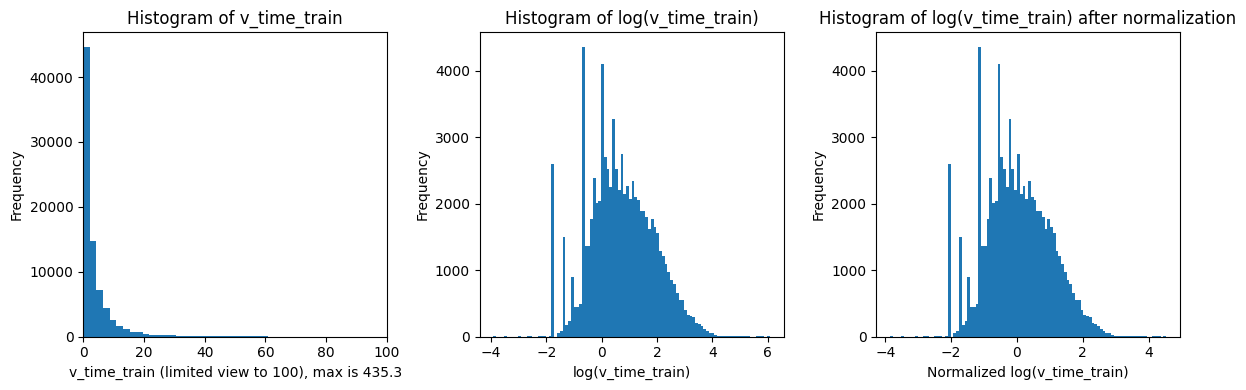

In [23]:
def standardize_tensor(tensor, mean=None, std=None):
    if mean is None or std is None:
        # Calculate mean and std if not provided
        mean = torch.mean(tensor)
        std = torch.std(tensor)
    return (tensor - mean) / std, mean, std

def reverse_standardize_tensor(tensor, mean, std):
    return tensor * std + mean

# Standardize the tensors
x_emb_train, mean, std = standardize_tensor(x_emb_train)
x_emb_test, _, _ = standardize_tensor(x_emb_test, mean, std)

x_emb_train_pca, mean, std = standardize_tensor(x_emb_train_pca)
x_emb_test_pca, _, _ = standardize_tensor(x_emb_test_pca, mean, std)

# normalize the first and last elements of d_demo_train and d_demo_test aka age and distance
d_demo_train[:,0], mean, std = standardize_tensor(d_demo_train[:,0])
d_demo_test[:,0], _, _ = standardize_tensor(d_demo_test[:,0], mean, std)
d_demo_train[:,-1], mean, std = standardize_tensor(d_demo_train[:,-1])
d_demo_test[:,-1], _, _ = standardize_tensor(d_demo_test[:,-1], mean, std)

fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].hist(v_time_train, bins=200)
ax[0].set_title("Histogram of v_time_train")
ax[0].set_xlabel(f"v_time_train (limited view to 100), max is {torch.max(v_time_train):.1f}")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(0, 100)

v_time_train_log = torch.log(v_time_train + 1e-6)  # Adding 1e-6 to avoid log(0)
#plot histogram of v_time_train_log
ax[1].hist(v_time_train_log.cpu().numpy(), bins=100)
ax[1].set_title("Histogram of log(v_time_train)")
ax[1].set_xlabel("log(v_time_train)")
ax[1].set_ylabel("Frequency")


v_time_train_log, v_time_mean, v_time_std = standardize_tensor(v_time_train_log)
ax[2].hist(v_time_train_log.cpu().numpy(), bins=100)
ax[2].set_title("Histogram of log(v_time_train) after normalization")
ax[2].set_xlabel("Normalized log(v_time_train)")
ax[2].set_ylabel("Frequency")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "v_time_histograms.pdf"))
plt.show()

v_time_test_log = torch.log(v_time_test + 1e-6)  # Adding 1e-6 to avoid log(0)
v_time_test_log, _, _ = standardize_tensor(v_time_test, v_time_mean, v_time_std)


## Train

The generative process we are training is below. The $\beta_0$ and $\gamma_0$ are initialized with a prior with the empiric average. The $\lambda$ is clamped within $[\exp (-5.0), \exp (5.4)]$


**Generative Process:**

1) Draw $\theta \sim \text{Dirichlet}(\alpha)$

2) For each group, $g$, in $G$:

    2a) Draw $\beta_g \sim \mathcal{N}(0,\bm{I}_K)$

    2b) Draw $\gamma_g \sim \mathcal{N}(0,\bm{I}_K)$

    2c) Draw $\sigma_g \sim \text{HalfCauchy}(5)$

3) For each patient, $p$, in patients:

    3a) Draw group assignment $\bm{g}_p \sim \text{Categorical}(\theta)$

    3b) $\tilde{\mu} = \beta_{0}^g + \bm{\beta}_x^g \bm{x}_p + \bm{\beta}_d^g \bm{d}_p$
    
    3c) $\tilde{\lambda} = \exp (\gamma_{0}^g + \bm{\gamma}_x^g \bm{x}_p + \bm{\gamma}_d^g \bm{d}_p)$
    
    3d) Draw $\bm{v}_p \sim \text{LogNormal}(\tilde{\mu}, \sigma_{g_p})$ 
    
    3e) Draw $\bm{c}_p \sim \text{Poisson}(\tilde{\lambda})$ 

In [ ]:
pyro.set_rng_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.set_default_device(device)
torch.set_default_dtype(torch.float64)

# create a CUDA-based RNG for DataLoader
cuda_gen = torch.Generator(device=device).manual_seed(42)

x_emb_train = x_emb_train.to(device)
x_emb_train_pca = x_emb_train_pca.to(device)
d_demo_train = d_demo_train.to(device)
v_time_train  = v_time_train.to(device)
a_count_train = a_count_train.to(device)
v_time_train_log = v_time_train_log.to(device)

N = len(x_emb_train)
batch_size = 2**11 #max is 2**17
dataset = TensorDataset(x_emb_train_pca, d_demo_train, v_time_train_log, a_count_train)
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        generator=cuda_gen, 
                        num_workers=4,
                        persistent_workers=True
                    )


G=10

# Setup SVI
optimizer = ClippedAdam({"lr": 1e-4})

svi = SVI(MixtureModel, MixtureModelGuide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1))
losses = []
# Training loop
def train_batch(num_epochs=1000):
    #losses = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        for x_mb, d_mb, v_mb, c_mb in dataloader:
            total_loss += svi.step(x_mb, d_mb, v_mb, c_mb, G, device, batch_size=len(x_mb))
        losses.append(total_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch} loss = {total_loss:.2f}")
    #return losses

def train(num_steps=1000):
    #losses = []
    for step in range(num_steps):
        loss = svi.step(x_emb_train, d_demo_train, v_time_train_log, a_count_train, G, device)
        losses.append(loss)
        
        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")
    #return losses

# To run:
#num_steps = 10000
#train(num_steps)  # adjust steps

train_batch(num_epochs=2000)  # adjust epochs
# After training, inspect pyro.param values for cluster parameters and q_alpha

# 9 minutes on GPU, 1000 samples, 10000 steps
# 4 minutes on GPU, 100000 samples, 1000 steps
# 22 minutes on GPU, 100000 samples, 10000 steps
# 172 minutes on GPU, 100000 samples, 100000 steps
# 87 minutes on GPU with mean VI (calculating for each group), 10 groups, 100000 samples, 2200 steps
# After mean over z (10 groups) about a min per 10 epochs.
# 27 min, batch size 2**12, 100000 samples, 1000 epochs, and decreasing loss!!!!
# 82 min, batch size 2**10, 100000 samples, 1000 epochs, and decreasing loss!!!!
# 180 min, batch size 2**11, all samples, 1173 epochs, and decreasing loss!!!!
# 74 min, batch size 2**11, 100000 samples, 2000 epochs, pca and decreasing loss!!!!

Using device: cuda
Epoch 0 loss = 213612.91
Epoch 10 loss = 226117.56
Epoch 20 loss = 210463.49
Epoch 30 loss = 210360.15
Epoch 40 loss = 199448.52
Epoch 50 loss = 180419.73
Epoch 60 loss = 175609.21
Epoch 70 loss = 194584.76
Epoch 80 loss = 183433.07
Epoch 90 loss = 184467.16
Epoch 100 loss = 157699.99
Epoch 110 loss = 170909.29
Epoch 120 loss = 186362.53
Epoch 130 loss = 148438.58
Epoch 140 loss = 161716.87
Epoch 150 loss = 161006.22
Epoch 160 loss = 169175.28
Epoch 170 loss = 148348.21
Epoch 180 loss = 142036.89
Epoch 190 loss = 149328.26
Epoch 200 loss = 143063.11
Epoch 210 loss = 134830.79
Epoch 220 loss = 141911.64
Epoch 230 loss = 136213.90
Epoch 240 loss = 139642.09
Epoch 250 loss = 120417.94
Epoch 260 loss = 116619.35
Epoch 270 loss = 127731.63
Epoch 280 loss = 115671.71
Epoch 290 loss = 119017.73
Epoch 300 loss = 123101.21
Epoch 310 loss = 122950.54
Epoch 320 loss = 124795.69
Epoch 330 loss = 112549.86
Epoch 340 loss = 110272.82
Epoch 350 loss = 101543.08
Epoch 360 loss = 955

In [15]:
train_batch(num_epochs=1000)  # adjust epochs

Epoch 0 loss = -373725.77
Epoch 10 loss = -362802.15
Epoch 20 loss = -375898.96
Epoch 30 loss = -357193.66
Epoch 40 loss = -371921.74
Epoch 50 loss = -370099.08
Epoch 60 loss = -374887.71
Epoch 70 loss = -382024.81
Epoch 80 loss = -368092.58
Epoch 90 loss = -389809.62
Epoch 100 loss = -387322.06
Epoch 110 loss = -391108.56
Epoch 120 loss = -375084.16
Epoch 130 loss = -403201.18
Epoch 140 loss = -394017.57
Epoch 150 loss = -397198.68
Epoch 160 loss = -406070.65
Epoch 170 loss = -403453.06
Epoch 180 loss = -393455.00
Epoch 190 loss = -406464.27
Epoch 200 loss = -395362.96
Epoch 210 loss = -405299.08
Epoch 220 loss = -424370.56
Epoch 230 loss = -400428.76
Epoch 240 loss = -384598.19
Epoch 250 loss = -442548.31
Epoch 260 loss = -417385.00
Epoch 270 loss = -420056.00
Epoch 280 loss = -426987.16
Epoch 290 loss = -419241.62
Epoch 300 loss = -443643.52
Epoch 310 loss = -446822.37
Epoch 320 loss = -432556.55
Epoch 330 loss = -422968.86
Epoch 340 loss = -426220.35
Epoch 350 loss = -435382.91
Epo

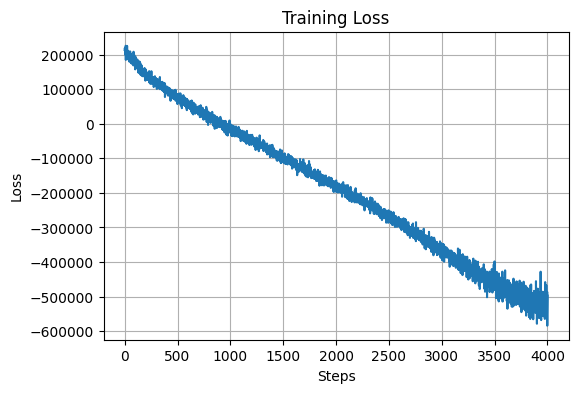

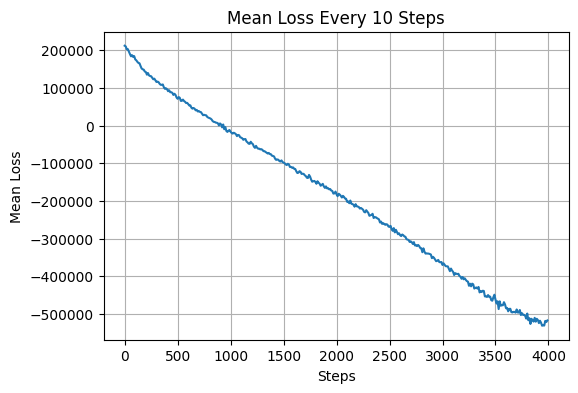

In [16]:
num_steps = len(losses)
# plot loss
def plot_loss(losses):
    plt.figure(figsize=(6, 4))
    plt.plot(losses)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    #plt.yscale("log")
    plt.grid()
    plt.savefig(os.path.join(save_dir, f"loss_plot_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
    plt.show()

# Call the function to plot loss
plot_loss(losses)

# Calculate mean losses for every 10 steps
def calculate_mean_losses(losses, step_size=10):
    mean_losses = [np.mean(losses[i:i + step_size]) for i in range(0, len(losses), step_size)]
    return mean_losses

# Plot the mean losses
def plot_mean_losses(losses, step_size=10):
    mean_losses = calculate_mean_losses(losses, step_size=step_size)

    plt.figure(figsize=(6, 4))
    plt.plot(range(0, len(mean_losses) * step_size, step_size), mean_losses)
    plt.xlabel("Steps")
    plt.ylabel("Mean Loss")
    plt.title(f"Mean Loss Every {step_size} Steps")
    #plt.yscale("log")
    plt.grid()
    plt.savefig(os.path.join(save_dir, f"mean_loss_plot_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
    plt.show()

# Call the function to plot mean losses
plot_mean_losses(losses, step_size=10)

Predicted time spent:
Total test predictions:  19983
Total finite predictions:  19979
Predictions below threshold:  19853
Minimum -1e-06 and maximum inf

Predicted counts:
Total test predictions:  19983
Minimum 29.905 and maximum 128.255


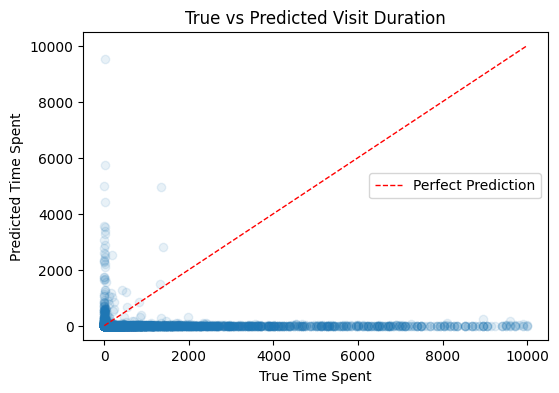

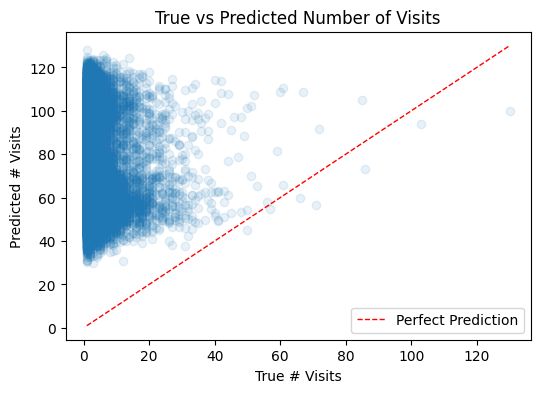

In [24]:
# Plot predictions on test set
x_emb_test = x_emb_test.to(device).to(torch.float64)
d_demo_test = d_demo_test.to(device).to(torch.float64)
v_time_test = v_time_test.to(device).to(torch.float64)
v_time_test_log = v_time_test_log.to(device).to(torch.float64)
a_count_test = a_count_test.to(device).to(torch.float64)

predictive = Predictive(
    MixtureModel,
    guide=MixtureModelGuide,
    num_samples=200,                      # number of posterior draws
    return_sites=["obs_logtime", "obs_visits"]
)

# 3. Draw posterior‐predictive samples
samples = predictive(x_emb_test_pca, d_demo_test, None, None, G, device)

# 4. Compute the posterior mean prediction for each outcome
#pred_time   = samples["obs_time"].mean(dim=0).cpu().numpy()
pred_log = samples["obs_logtime"].mean(0)
pred_log = reverse_standardize_tensor(pred_log, v_time_mean, v_time_std)
pred_time = torch.exp(pred_log) - 1e-6
pred_time = pred_time.cpu().numpy()
pred_visits = samples["obs_visits"].mean(dim=0).cpu().numpy()

# 5. Get the “true” values
v_time_test_log_reversed = reverse_standardize_tensor(v_time_test_log, v_time_mean, v_time_std)
true_time = torch.exp(v_time_test_log_reversed) - 1e-6
true_time   = true_time.cpu().numpy()
true_visits = a_count_test.cpu().numpy()

threshold = 1e4

# Create a valid mask
print("Predicted time spent:")
print("Total test predictions: ", len(pred_time))
print("Total finite predictions: ", sum(np.isfinite(pred_time)))
print("Predictions below threshold: ", sum(pred_time < threshold))
print(f"Minimum {pred_time.min()} and maximum {pred_time.max()}")

print("\nPredicted counts:")
print("Total test predictions: ", len(pred_visits))
print(f"Minimum {pred_visits.min()} and maximum {pred_visits.max()}")


mask = np.isfinite(pred_time) & (pred_time < threshold) & (true_time < threshold)
# Apply the mask to the true and predicted values
true_time = true_time[mask]
pred_time = pred_time[mask]

# 6. Plot True vs Predicted for time
if true_time.size == 0 or pred_time.size == 0:
    print("No valid data to plot.")
else:
    plt.figure(figsize=(6, 4))
    plt.scatter(true_time, pred_time,  alpha=0.1)
    plt.plot([true_time.min(), true_time.max()],
            [true_time.min(), true_time.max()],
             'r--', linewidth=1,label="Perfect Prediction")
    plt.xlabel("True Time Spent")
    plt.ylabel("Predicted Time Spent")
    plt.title("True vs Predicted Visit Duration")
    plt.legend()
    plt.savefig(os.path.join(save_dir,f"time_pred_true_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
    plt.show()

# 7. Plot True vs Predicted for visits
plt.figure(figsize=(6, 4))
plt.scatter(true_visits, pred_visits, alpha=0.1)
plt.plot([true_visits.min(), true_visits.max()],
         [true_visits.min(), true_visits.max()],
          'r--', linewidth=1, label="Perfect Prediction")
plt.xlabel("True # Visits")
plt.ylabel("Predicted # Visits")
plt.title("True vs Predicted Number of Visits")
plt.legend()
plt.savefig(os.path.join(save_dir,f"count_pred_true_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
plt.show()

1.0 148.0


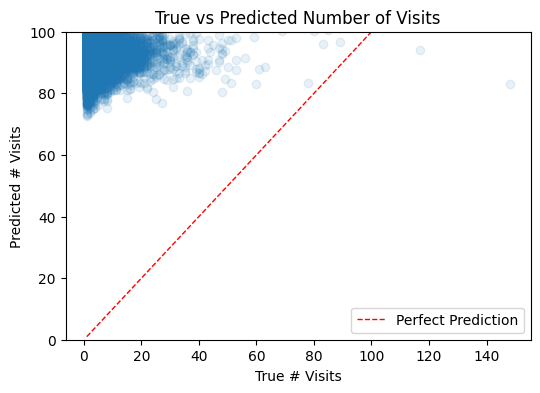

In [ ]:
print(true_visits.min(), true_visits.max())
plt.figure(figsize=(6, 4))
plt.scatter(true_visits, pred_visits, alpha=0.1)
plt.plot([true_visits.min(), true_visits.max()],
         [true_visits.min(), true_visits.max()],
          'r--', linewidth=1, label="Perfect Prediction")
plt.xlabel("True # Visits")
plt.ylabel("Predicted # Visits")
plt.title("True vs Predicted Number of Visits")
plt.ylim(0, 100)
plt.legend()
plt.show()

In [11]:
def save_model_and_losses(svi, losses, model_path="model_params.pt", losses_path="losses.npy"):
    """
    Save the model parameters and losses to files.

    Args:
        svi (pyro.infer.SVI): The SVI object containing the model parameters.
        losses (list): List of losses recorded during training.
        model_path (str): Path to save the model parameters.
        losses_path (str): Path to save the losses.
    """
    # Save model parameters
    pyro_params = {name: pyro.param(name).detach().cpu() for name in pyro.get_param_store().keys()}
    torch.save(pyro_params, model_path)
    print(f"Model parameters saved to {model_path}")

    # Save losses
    np.save(losses_path, np.array(losses))
    print(f"Losses saved to {losses_path}")

model_path = os.path.join(save_dir, f"model_params_{num_steps}.pt")
losses_path = os.path.join(save_dir, f"losses_{num_steps}.npy")
save_model_and_losses(svi, losses, model_path=model_path, losses_path=losses_path)

Model parameters saved to outputs\mean_vi_no_clamp_on_mu_10_11_batch_pca\model_params_2000.pt
Losses saved to outputs\mean_vi_no_clamp_on_mu_10_11_batch_pca\losses_2000.npy
